In [1]:
using Revise 
using EuclidianNormalizingFlows

using BAT
using Distributions
using Optimisers
using FunctionChains
using ArraysOfArrays
using LinearAlgebra
using ValueShapes
using StatsBase
using FileIO
using JLD2
using CUDA
using CUDAKernels
using KernelAbstractions
using Flux
using PyPlot

In [5]:
n_smpls = 10^5

n_dims = 2
n_modes = 10

mvns = [MvNormal(10 .*rand(n_dims), 0.5 * abs(randn(1)[1]) .* I(n_dims)) for i in 1:n_modes]
d = MixtureModel(mvns)
importance_density = MvNormal(zeros(n_dims), I)
wanna_use_GPU = true
_device = wanna_use_GPU ? KernelAbstractions.get_device(CUDA.rand(10)) : KernelAbstractions.get_device(rand(10))
samples = bat_sample(d, BAT.IIDSampling(nsamples=n_smpls)).result;
smpls_flat = gpu(flatview(unshaped.(samples.v)));
samples_nested = wanna_use_GPU ? nestedview(gpu(smpls_flat)) : nestedview(smpls_flat);

proposal_density = convert(BAT.AbstractMeasureOrDensity, BAT.StandardMvNormal(n_dims))   
proposal_samples = bat_sample(proposal_density, 
                    BAT.IIDSampling(nsamples= n_smpls)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44


+++ Starting round 1
+++ Starting round 2
 22.705738 seconds (16.44 M allocations: 57.960 GiB, 15.05% gc time, 0.10% compilation time)
integral_ghm = 0.9936371893289837
variance_ghm = 0.00017446587294481155
 23.695893 seconds (138.09 M allocations: 22.019 GiB, 12.12% gc time)
integral_bs = 0.9984 ± 0.00033


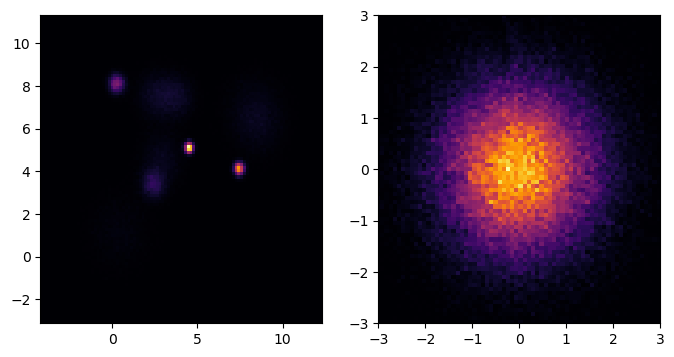

(-3.0, 3.0)

In [6]:
nbatches = 10
nepochs = 100
K = 40

blocks = get_flow_musketeer(n_dims,_device,K)
lr = fill(3f-3, length(blocks.fs))
trained_blocks = Function[AdaptiveScaleShift()]
hists = Vector[]

smpls_train = samples_nested;

@time begin
    smpls_train = nestedview(trained_blocks[1](smpls_flat))
    
    for i in 1:n_dims
        println("+++ Starting round $i")
        
        r = optimize_whitening(smpls_train, 
            blocks.fs[1+i],
            Optimisers.Adam(lr[i]),
            nbatches=nbatches,
            nepochs=nepochs, 
            shuffle_samples =false)
            
        trained_trafo = r.result
        push!(trained_blocks, trained_trafo)
        push!(hists, r.negll_history)
        smpls_train = nestedview(trained_trafo(flatview(smpls_train)))
    end
end

push!(trained_blocks, AdaptiveScaleShift())
trained_flow = fchain(trained_blocks)

smpls_transformed, ladj_trafo = EuclidianNormalizingFlows.with_logabsdet_jacobian(trained_flow, smpls_flat)

smpls_transformed = cpu(smpls_transformed)
smpls_flat_cpu = cpu(smpls_flat)

integral_ghm, variance_ghm = ghm_integration(smpls_transformed, samples.logd, vec(cpu(ladj_trafo)), importance_density)

@show integral_ghm
@show variance_ghm

@time begin
    target_density = BAT.Transformed(convert(BAT.AbstractMeasureOrDensity,d), 
                                     cpu(trained_flow), 
                                     BAT.TDLADJCorr()
                                    )

    target_samples = DensitySampleVector(nestedview(cpu(smpls_transformed)), 
                                         samples.logd - vec(cpu(ladj_trafo))
                                        )

    integral_bs = BAT.bridge_sampling_integral(target_density,
                                               target_samples, 
                                               proposal_density,
                                               proposal_samples,
                                               true)
end
@show integral_bs

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [100,100], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:]), maximum(smpls_flat_cpu[1,:])])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:]), maximum(smpls_flat_cpu[2,:])])
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [100,100], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

integral_ghm = 0.9793755775452184
variance_ghm = 0.00348342495918761
 37.145126 seconds (171.37 M allocations: 23.855 GiB, 9.62% gc time, 31.53% compilation time)
integral_bs = 0.99828 ± 0.00043


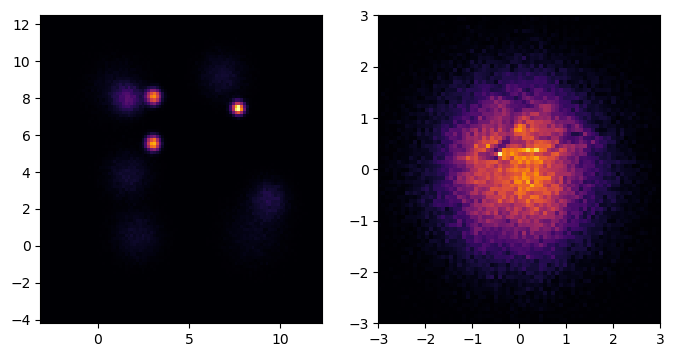

(-3.0, 3.0)

In [4]:
smpls_transformed, ladj_trafo = EuclidianNormalizingFlows.with_logabsdet_jacobian(trained_flow, smpls_flat)

smpls_transformed = cpu(smpls_transformed)
smpls_flat_cpu = cpu(smpls_flat)

integral_ghm, variance_ghm = ghm_integration(smpls_transformed, samples.logd, vec(cpu(ladj_trafo)), importance_density)

@show integral_ghm
@show variance_ghm

@time begin
    target_density = BAT.Transformed(convert(BAT.AbstractMeasureOrDensity,d), 
                                     cpu(trained_flow), 
                                     BAT.TDLADJCorr()
                                    )

    target_samples = DensitySampleVector(nestedview(cpu(smpls_transformed)), 
                                         samples.logd - vec(cpu(ladj_trafo))
                                        )

    integral_bs = BAT.bridge_sampling_integral(target_density,
                                               target_samples, 
                                               proposal_density,
                                               proposal_samples,
                                               true)
end
@show integral_bs

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [100,100], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:]), maximum(smpls_flat_cpu[1,:])])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:]), maximum(smpls_flat_cpu[2,:])])
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [100,100], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

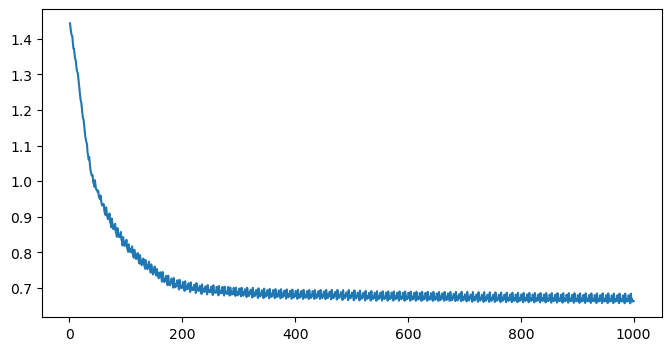

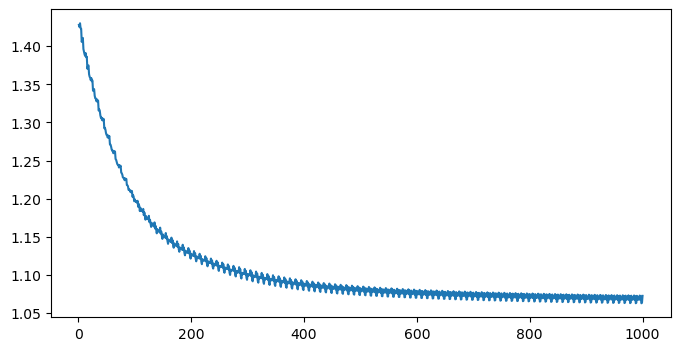

In [5]:
for i in 1:length(hists)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists[i]), hists[i])
end

In [13]:
smpls_transformed

2×100000 Matrix{Float32}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN